# Packges

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from glob import glob
from tqdm import tqdm
from pathlib import Path
from keras.models import Sequential,model_from_json
from keras.layers import Activation, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay 
import itertools

# GPU Config

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*10)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Functions

In [4]:
def plot_confusion_matrix(cm: np.ndarray,
                          target_names: list,
                          title: str='Confusion matrix',
                          cmap: str=None,
                          normalize: bool=True):
    '''given a sklearn confusion matrix (cm), make a nice plot

    Args:
        cm:           confusion matrix from sklearn.metrics.confusion_matrix

        target_names: given classification classes such as [0, 1, 2]
                      the class names, for example: ['high', 'medium', 'low']

        title:        the text to display at the top of the matrix

        cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                      see http://matplotlib.org/examples/color/colormaps_reference.html
                      plt.get_cmap('jet') or plt.cm.Blues

        normalize:    If False, plot the raw numbers
                      If True, plot the proportions
    '''

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Parameters

In [5]:
def evaluation(model_path, model_name, test_dataset, IMG_WIDTH=128, IMG_HEIGHT=128 ):
    # load json and create model
    json_file = open(str(Path(model_path , f'{model_name}.json')), 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(str(Path(model_path, f'{model_name}.h5')))
    print("Loaded model from disk") 

    # Datasets
    cats = glob(
        str(
            Path(
                test_dataset,
                'Cat',
                '*.jpg'
            )
        )
    )

    dogs = glob(
        str(
            Path(
                test_dataset,
                'Dog',
                '*.jpg'
            )
        )
    )

    dataset = pd.concat(
        [
            pd.DataFrame(
                {
                    'path':cats,
                    'class':[1]*len(cats)
                }
            ),
            pd.DataFrame(
                {
                    'path':dogs,
                    'class':[0]*len(dogs)
                }
            )
        ]
    )

    # list
    X_test = []
    y_test = []

    for idx, row in dataset.iterrows():
        img = Image.open(row['path'])
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        if model_name == 'Model_Depth Map':
            img = img.convert('L')
        img = np.array(img)
        img = img * (1/255)
        if model_name == 'Model_Depth Map':
            img = np.expand_dims(img, -1)
        elif model_name == 'Model_Color':
            #img = np.expand_dims(img, 3)
            pass

        X_test.append(img)
        y_test.append(row['class'])


    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = np.expand_dims(y_test, -1)

    # Predictions
    with tf.device('/device:GPU:0'):
     y_predictions = model.predict(x=X_test)

    THRESHOLD = 0.5
    y_predict_class = []

    for prob in y_predictions:
        index = np.argmax(prob)
        if index == 1:
            y_predict_class.append(1)
        elif index == 0:
            y_predict_class.append(0)
    
    confusion_matrix(
            y_true = y_test.reshape(-1), 
            y_pred = y_predict_class
        )

    tn, fp, fn, tp = confusion_matrix(
        y_true = y_test.reshape(-1), 
        y_pred = y_predict_class).ravel()
    
    recall_cats    = tp / (tp + fn)
    precision_cats = tp / (tp + fp)
    fscore_cats =  (2*recall_cats*precision_cats) /  (recall_cats + precision_cats)

    recall_dogs    = tn / (fp + tn)
    precision_dogs = tn / (tn + fn)
    fscore_dogs =  (2*recall_dogs*precision_dogs) /  (recall_dogs + precision_dogs)

    accuracy = (tp + tn) / sum([tn, fp, fn, tp])

    plot_confusion_matrix(
        cm = confusion_matrix(
            y_true = y_test.reshape(-1), 
            y_pred = y_predict_class), 
        target_names=['0','1'],
        normalize=False,
        title='Matriz de Confusión: Clase Cat (1) & Clase Dog (0)',
        cmap=plt.cm.Blues
        )
    
    print(f'Recall Cat {recall_cats:,.2f}')
    print(f'Precision Cat {precision_cats:,.2f}')
    print(f'Fscore Cat {fscore_cats:,.2f}')
    print('--------------------------------')
    print(f'Recall Dog {recall_dogs:,.2f}')
    print(f'Precision Dog {precision_dogs:,.2f}')
    print(f'Fscore Dog {fscore_dogs:,.2f}')
    print('--------------------------------')
    print(f'Accuracy {accuracy:,.2f}')

# Gray Scale Results

In [6]:
# evaluation(
#     model_path = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models'), 
#     model_name = 'Model_Depth Map', 
#     test_dataset = Path(r'D:\ML Datasets\kagglecatsanddogs_5340\Split\Test\Color')
# )

# Color results

Loaded model from disk
71/71 [==============================] - 3s 7ms/step


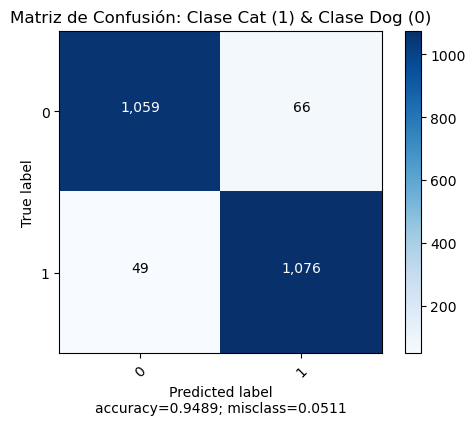

Recall Cat 0.96
Precision Cat 0.94
Fscore Cat 0.95
--------------------------------
Recall Dog 0.94
Precision Dog 0.96
Fscore Dog 0.95
--------------------------------
Accuracy 0.95


In [7]:
RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT = 128, 128

evaluation(
    model_path = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models'), 
    model_name = f'Model_Color_{RESCALE_IMG_WIDTH}_{RESCALE_IMG_HEIGHT}', 
    test_dataset = Path(r'D:\ML Datasets\kagglecatsanddogs_5340\Split\Test\Color',
    IMG_WIDTH=RESCALE_IMG_WIDTH, 
    IMG_HEIGHT=RESCALE_IMG_HEIGHT)
)

# Edited Results


Loaded model from disk
71/71 [==============================] - 1s 8ms/step


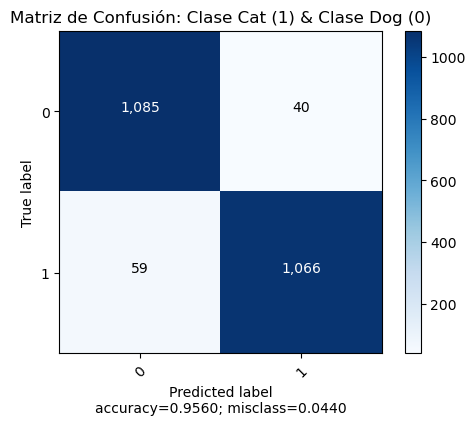

Recall Cat 0.95
Precision Cat 0.96
Fscore Cat 0.96
--------------------------------
Recall Dog 0.96
Precision Dog 0.95
Fscore Dog 0.96
--------------------------------
Accuracy 0.96


In [8]:
RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT = 128, 128

evaluation(
    model_path = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models'), 
    model_name = f'Model_Edited_{RESCALE_IMG_WIDTH}_{RESCALE_IMG_HEIGHT}', 
    test_dataset = Path(r'D:\ML Datasets\kagglecatsanddogs_5340\Split\Test\Edited'),
    IMG_WIDTH=RESCALE_IMG_WIDTH, 
    IMG_HEIGHT=RESCALE_IMG_HEIGHT
)